In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Differing Phyisical Dimensions
BUG can run time evolutions for systems with different physical dimensions for the different sites.

In [20]:
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.operators.common_operators import bosonic_operators

In [21]:
num_sites = 5
dims = list(range(2, 2 + num_sites))
print(dims)
create_ops = {}
destroy_ops = {}
num_ops = {}
for dim in dims:
    create_op, destroy_op, num_op = bosonic_operators(dim)
    create_ops["create" + str(dim)] = create_op
    destroy_ops["destroy" + str(dim)] = destroy_op
    num_ops["num" + str(dim)] = num_op
ham = Hamiltonian()
for i, dim in enumerate(dims):
    num_op = TensorProduct({"site" + str(i): "num" + str(dim)})
    ham.add_term(num_op)
    if i < num_sites - 1:
        term1 = TensorProduct({"site" + str(i): "create" + str(dim),
                               "site" + str(i + 1): "destroy" + str(dim+1)})
        term2 = TensorProduct({"site" + str(i): "destroy" + str(dim),
                               "site" + str(i + 1): "create" + str(dim+1)})
        ham.add_multiple_terms([term1, term2])
ham.conversion_dictionary.update(create_ops)
ham.conversion_dictionary.update(destroy_ops)
ham.conversion_dictionary.update(num_ops)
ham.include_identities(dims)

[2, 3, 4, 5, 6]


In [22]:
from pytreenet.ttns.ttns import TTNS
from pytreenet.ttno.ttno_class import TTNO
from pytreenet.operators.common_operators import ket_i
from pytreenet.special_ttn.mps import MatrixProductState

In [23]:
mps_tensors = [ket_i(dim-2,dim) for dim in dims]
for i, tensor in enumerate(mps_tensors):
    if i in [0, len(mps_tensors)-1]:
        tensor = tensor.reshape((1,)+tensor.shape)
    else:
        tensor = tensor.reshape((1,1)+tensor.shape)
    mps_tensors[i] = tensor
mps = MatrixProductState.from_tensor_list(mps_tensors,
                                          root_site=2)
mpo = TTNO.from_hamiltonian(ham, mps)

In [27]:
eval_ops = {}
for i, dim in enumerate(dims):
    _, _, num_op = bosonic_operators(dim)
    num_op = TensorProduct({"site" + str(i): num_op})
    eval_ops["site"+str(i)] = num_op

In [25]:
from pytreenet.time_evolution.bug import BUG, BUGConfig
from pytreenet.time_evolution.time_evolution import TimeEvoMode

In [26]:
config = BUGConfig(time_evo_mode=TimeEvoMode.EXPM)
bug = BUG(mps, mpo, 0.01, 1,
          eval_ops,
          config=config)
bug.run()

100%|██████████| 101/101 [00:02<00:00, 46.37it/s]


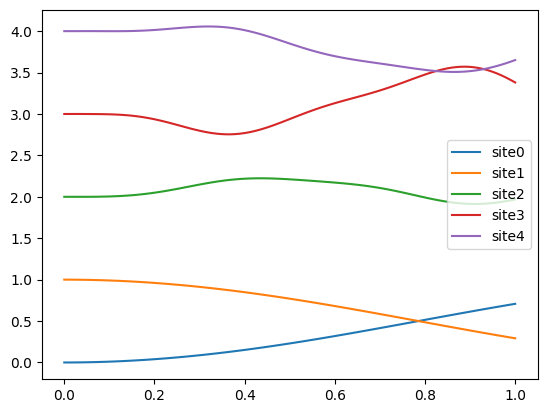

In [28]:
import matplotlib.pyplot as plt
results = bug.results
times = results.times()
for key in eval_ops.keys():
    plt.plot(times, results.operator_result(key, realise=True),
             label=key)
plt.legend()
plt.show()